# 6-1: Visualization

I bet by the end of last lesson, you were tired of looking at giant tables. Sometimes tabular representation is the right call to tell the story of your data, but other times, a picture is worth more than ten thousand table rows.

And when you have that many, it's definitely best to avoid looking at them all row-by-row. To prove that point, we're going to work a very large file of many log entries: in this case, Sysmon logs from a Conti Ransomware event. It's so big, in fact, we can't include the file in the repository. So let's download it now.

In [ ]:
# Download logs
! wget https://media.githubusercontent.com/media/splunk/attack_data/master/datasets/malware/conti/conti-cobalt/windows-sysmon.log

## Parsing Sysmon Logs

There are myriad PowerShell tools that will parse Sysmon logs and allow incident responders and threat hunters to quickly, efficiently review event data. But we're not in PowerShell, are we? Unfortunately, I was unable to find anything in the Python universe to do the same.

So I wrote one.

The code in `sysmon.py` is part of my own library of tools. Feel free to read through it, modify it, and expand it! What this module does is deconstruct WinEvent XML with `BeautifulSoup` to produce `SysmonEvent` objects, each with useful properties we can access and compare.

There's also a handy `load_xml()` function that will load the raw XML directly into a list of `SysmonEvent` objects. There's another `load_evtx()` function for files in the binary EVTX format, but that's not what we have here.

This file will be our starting point for this lesson. Let's get those events!

In [1]:
# Import Sysmon module and Pandas, because of course
import sys
sys.path.append("../lib/")
from sysmon import load_xml
import pandas as pd

In [2]:
# Load Sysmon Events from the `windows-sysmon.log` file.
evts = load_xml("windows-sysmon.log")

If all went well, we should have a nice list of events. Before even loading this into a DataFrame, let's look at how many events we have.

In [3]:
# len of evts
len(evts)

27367

So that's...a lot. But what does one of these things look like, anyway? Let's examine one of them

In [4]:
# Look at the first Event object
evts[0]

Okay so that could be clearer. What does the object contain? One easy way to find out is with the built-in `vars()` function, which will extract the attributes of an object to a `dict`.

In [5]:
# dict-ify our evt
vars(evts[0])

{'soup': <event xmlns="http://schemas.microsoft.com/win/2004/08/events/event"><system><provider guid="{5770385F-C22A-43E0-BF4C-06F5698FFBD9}" name="Microsoft-Windows-Sysmon"></provider><eventid>11</eventid><version>2</version><level>4</level><task>11</task><opcode>0</opcode><keywords>0x8000000000000000</keywords><timecreated systemtime="2021-08-09T18:19:38.770881500Z"></timecreated><eventrecordid>25191072</eventrecordid><correlation></correlation><execution processid="1224" threadid="3140"></execution><channel>Microsoft-Windows-Sysmon/Operational</channel><computer>win-dc-58.attackrange.local</computer><security userid="S-1-5-18"></security></system><eventdata><data name="RuleName">-</data><data name="UtcTime">2021-08-09 18:19:38.770</data><data name="ProcessGuid">{C2350C16-51BC-60F8-FFE8-01000000CF01}</data><data name="ProcessId">5088</data><data name="Image">C:\Program Files\SplunkUniversalForwarder\bin\splunk-winevtlog.exe</data><data name="TargetFilename">C:\Program Files\SplunkUni

There now, that's something. While different Event IDs will contain some different properties, each one contains:

* `user_id`
* `event_id`
* `time_created`
* `pid`

We can use `vars()` to quickly make a big ol messy DataFrame.

You might ask why we didn't do that in the first place. Sysmon Events are complicated enough that having the structure of these objects becomes more valuable in the long run. For now, let's try to make that DataFrame by giving Pandas the `vars()` result of our objects.

We're also going to drop the `soup` field because we don't need all that data, and it's gigantic.

In [6]:
df = pd.DataFrame([vars(e) for e in evts])
# Drop the sop column because we don't need it and it's huge
df.drop("soup", axis=1, inplace=True)

In [7]:
df

,user_id,event_id,time_created,pid,parent_pid,image,user,target_filename,src_ip,dest_ip,...,query_name,query_results,creation_utc_time,previous_creation_utc_time,source_pid,target_pid,source_image,target_image,new_thread_id,type
0,S-1-5-18,11,2021-08-09T18:19:38.770881500Z,5088.0,NaN,C:\Program Files\SplunkUniversalForwarder\bin\...,,C:\Program Files\SplunkUniversalForwarder\var\...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,S-1-5-18,23,2021-08-09T18:19:38.770395700Z,5088.0,NaN,C:\Program Files\SplunkUniversalForwarder\bin\...,NT AUTHORITY\SYSTEM,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,S-1-5-18,3,2021-08-09T18:19:38.954672600Z,960.0,NaN,C:\Program Files\SplunkUniversalForwarder\bin\...,NT AUTHORITY\SYSTEM,NaN,10.0.1.15,10.0.1.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,S-1-5-18,3,2021-08-09T18:19:38.954646300Z,5708.0,NaN,C:\Program Files\SplunkUniversalForwarder\etc\...,NT AUTHORITY\SYSTEM,NaN,10.0.1.15,10.0.1.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,S-1-5-18,23,2021-08-09T18:19:38.157677400Z,6092.0,NaN,C:\Program Files\SplunkUniversalForwarder\bin\...,NT AUTHORITY\SYSTEM,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27362,S-1-5-18,7,2021-08-09T18:32:37.189382200Z,7236.0,NaN,C:\Program Files\SplunkUniversalForwarder\bin\...,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27363,S-1-5-18,7,2021-08-09T18:32:37.186922900Z,7236.0,NaN,C:\Program Files\SplunkUniversalForwarder\bin\...,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27364,S-1-5-18,7,2021-08-09T18:32:37.186073400Z,7236.0,NaN,C:\Program Files\SplunkUniversalForwarder\bin\...,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27365,S-1-5-18,12,2021-08-09T18:32:37.166389900Z,8056.0,NaN,C:\Windows\SysWOW64\rundll32.exe,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There now, a proper `DataFrame`. But that's a table and this lesson is about visualizations! What kind of visualizations can we do? What about, say, a chart of Event IDs?

Easy enough, right? Kinda!

The good news is `DataFrames` have a built-in `plot` property that exposes all kinds of graphing features. They take some getting used to though, and they also require importing the `matplotlib` library. Let's take take of that before we do anything else.

In [8]:
# Import matplotlib
import matplotlib

`matplotlib` is basically an entire course, and I will not be going into every aspect of it. We'll take what we need to make basic visualizations with it.

To start, let's say we want a simple bar chart, showing the count of every Event ID. It seems simple, but fremember that right now our `DataFrame` has a row for every Event. It is not yet aggregated in any meaningful way. So up first, we know we'll have to `groupby()` and, since we want _how many_ events per, we'll use `.count()` as our aggregator. We'll even sort them for ease of use.

For ease, we'll save this slice as a new variable.

In [9]:
# Save the counts as a new slice. This is common when working with the data
# in multiple ways
event_counts = df.groupby("event_id").count().sort_values(by="pid", ascending=False)
event_counts

,user_id,time_created,pid,parent_pid,image,user,target_filename,src_ip,dest_ip,src_port,...,query_name,query_results,creation_utc_time,previous_creation_utc_time,source_pid,target_pid,source_image,target_image,new_thread_id,type
event_id,,,,,,,,,,,,,,,,,,,,,
7,9688,9688,9688,0,9688,9688,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,6243,6243,6243,0,6243,6243,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,2201,2201,2201,0,2201,2201,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1821,1821,1821,0,1821,1821,0,1821,1821,1821,...,0,0,0,0,0,0,0,0,0,0
11,1464,1464,1464,0,1464,1464,1464,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,1074,1074,1074,0,1074,1074,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,509,509,509,0,509,509,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,313,313,313,0,313,313,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,229,229,229,229,229,229,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now to move from a table to a graph. The built-in `plot.bar` will provide us a bar graph of this data!

Using the `plot` methods takes some practice. Most of the arguments it requires are named, not positional, so you need to be familiar with the spec. I always have the [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html) open when making these.

At base, the plot needs `x` and `y` values. The `x` axis is how we're grouping our data (`event_id`) in this case, and the `y` axis is our value to measure. Since we `count()`ed everything, we want to use a column that is present on all rows. `pid` will do nicely.

Let's try just that much.

In [10]:
event_counts.plot.bar(x="event_id", y="pid")

KeyError: 'event_id'

What?? What went wrong? `KeyError: 'event_id'`? How can that be?

Welcome to Pandas. Because we grouped by `event_id`, it is no longer an accessible column; it's the Index. The very thing we needed to do to shape our data removed the column we need for the chart.

But worry not, there's a solution: we can `reset_index()` to make the Index a RangeIndex once more and get our `event_ids` column back. Our data shape is the same, but now we have the column we need. One more time!

<AxesSubplot: xlabel='event_id'>

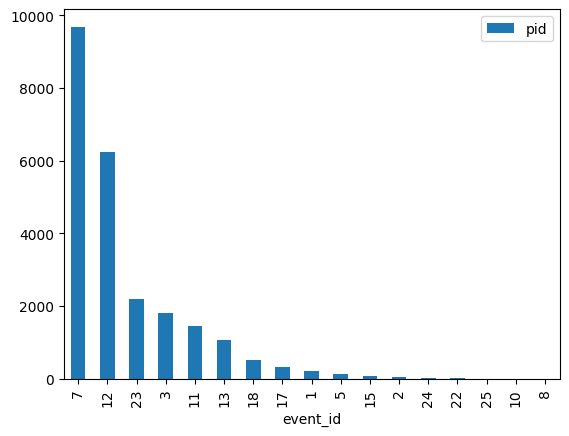

In [11]:
# Once more, but with a reset index
event_counts.reset_index().plot.bar(x="event_id", y="pid")

We made a thing! It could be prettier, but it's a graph nonetheless. `matplotlib` defaults aren't too shabby. In the next lesson we'll go over some more advanced graphing libraries, but there's more we can do to make this helpful. For one thing, every chart needs a title. Also, can we do something about those axes labels? Basic middle school science stuff.

The easiest way to make these modifications is to save the chart to a variable and work with it there. You can see above the chart that this is an `AxesSubplot` object. Commonly we'll name `Axes` objects `ax`. We can actually set the title with an argument to `plot.bar()`, but the label and the legend need methods on the axes.

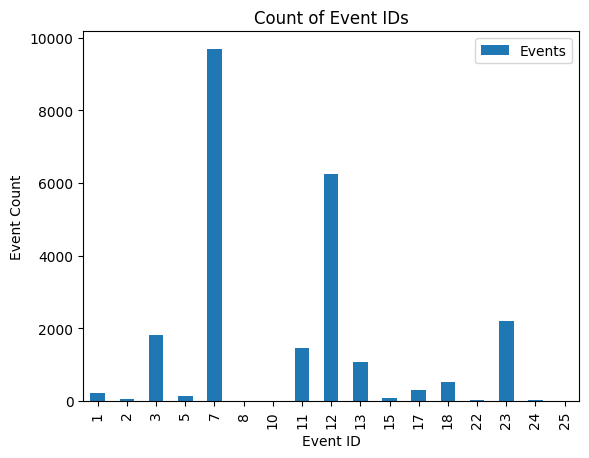

In [12]:
# Safe the axes object to manipulate it
ax = event_counts.reset_index().sort_values(by="event_id").plot.bar(x="event_id", y="pid", title="Count of Event IDs")
ax.set_xlabel("Event ID")
ax.set_ylabel("Event Count")
ax.legend(["Events"])


Much better! Now that we have the basics down, let's split our `DataFrame` a bit more to examine our data.

## Process Executions

Event ID 1 in Sysmon is a goldmine. Let's begin investigating process executions in our logs by isolating that Event ID

In [13]:
# Get all process execs
process_execs = df[df.event_id == 1]
# Get the shape of the new df
print(process_execs.shape)
print(process_execs.columns)
process_execs.head()

(229, 34)
Index(['user_id', 'event_id', 'time_created', 'pid', 'parent_pid', 'image',
       'user', 'target_filename', 'src_ip', 'dest_ip', 'src_port', 'dest_port',
       'integrity_levels', 'target_object', 'image_loaded', 'signed', 'hashes',
       'signature', 'signature_status', 'pipe_name', 'details', 'command_line',
       'parent_command_line', 'parent_image', 'query_name', 'query_results',
       'creation_utc_time', 'previous_creation_utc_time', 'source_pid',
       'target_pid', 'source_image', 'target_image', 'new_thread_id', 'type'],
      dtype='object')


,user_id,event_id,time_created,pid,parent_pid,image,user,target_filename,src_ip,dest_ip,...,query_name,query_results,creation_utc_time,previous_creation_utc_time,source_pid,target_pid,source_image,target_image,new_thread_id,type
57,S-1-5-18,1,2021-08-09T18:19:43.338852500Z,7376.0,3780.0,C:\Users\Administrator\Desktop\beacon.exe,ATTACKRANGE\Administrator,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
628,S-1-5-18,1,2021-08-09T18:19:52.900290900Z,7452.0,2792.0,C:\Program Files\SplunkUniversalForwarder\bin\...,NT AUTHORITY\SYSTEM,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
687,S-1-5-18,1,2021-08-09T18:19:52.365103500Z,7560.0,2792.0,C:\Program Files\SplunkUniversalForwarder\bin\...,NT AUTHORITY\SYSTEM,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
749,S-1-5-18,1,2021-08-09T18:19:53.501676400Z,940.0,2792.0,C:\Program Files\SplunkUniversalForwarder\bin\...,NT AUTHORITY\SYSTEM,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
857,S-1-5-18,1,2021-08-09T18:20:03.427898200Z,3636.0,960.0,C:\Program Files\SplunkUniversalForwarder\bin\...,NT AUTHORITY\SYSTEM,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Awesome, 229 events to work with. How might we visualize this data?

Perhaps as a starter we can look at the `image` field for rare occurrences. This can be done in tabular as well as graphical format. Let's get both going.

In [14]:
# Group by image
procs_by_image = process_execs.groupby("image").count().sort_values(by="pid", ascending=False)
procs_by_image

,user_id,event_id,time_created,pid,parent_pid,user,target_filename,src_ip,dest_ip,src_port,...,query_name,query_results,creation_utc_time,previous_creation_utc_time,source_pid,target_pid,source_image,target_image,new_thread_id,type
image,,,,,,,,,,,,,,,,,,,,,
C:\Program Files\SplunkUniversalForwarder\bin\splunk-powershell.exe,52,52,52,52,52,52,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C:\Program Files\SplunkUniversalForwarder\bin\splunk-admon.exe,26,26,26,26,26,26,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C:\Program Files\SplunkUniversalForwarder\bin\splunk-netmon.exe,26,26,26,26,26,26,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C:\Program Files\SplunkUniversalForwarder\bin\splunk-regmon.exe,26,26,26,26,26,26,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C:\Program Files\SplunkUniversalForwarder\bin\splunk-winprintmon.exe,26,26,26,26,26,26,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C:\Program Files\SplunkUniversalForwarder\bin\splunk-MonitorNoHandle.exe,26,26,26,26,26,26,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C:\Windows\System32\conhost.exe,11,11,11,11,11,11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C:\Windows\SysWOW64\cmd.exe,8,8,8,8,8,8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C:\Windows\System32\rundll32.exe,5,5,5,5,5,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I love this dataset; it's so clean. Real life doesn't always work like that. But even here, we can see some sus-looking images. `beacon.exe` indeed.

Does a chart of this information help us? I don't think it's super valuable as-is, but let's make one to see it anyhow.

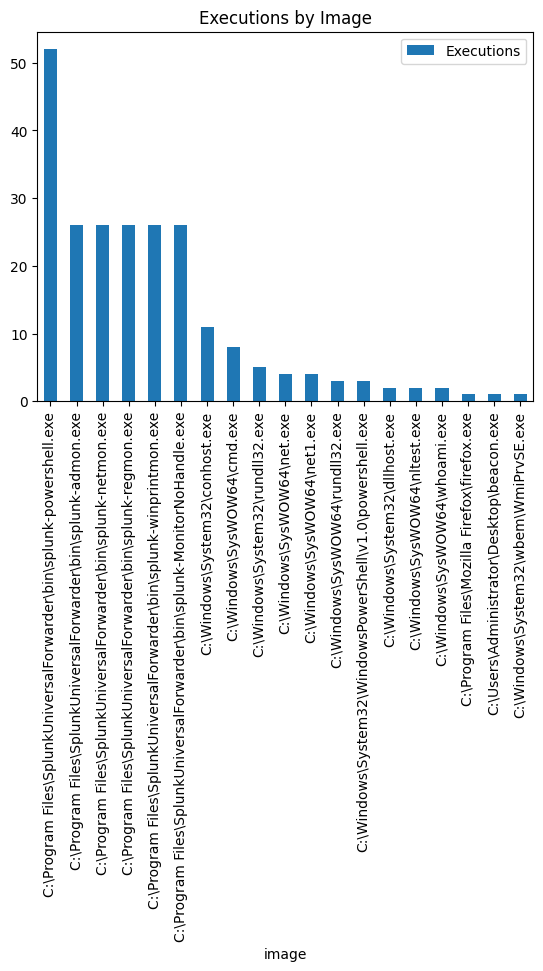

In [15]:
ax = procs_by_image.reset_index().plot.bar(x="image", y="pid", title="Executions by Image")
ax.set_xlabel("Image")
ax.set_ylabel("Execution Count")
ax.legend(["Executions"])

Which way did you tilt your head to look at that—left or right? The answer says a lot about you!

Didn't tilt your head at all? Okay, you _psychopath_.

But seriously, this isn't a great way to display this data. In the case of process executions, a table is better. Why did we do this at all then? To drive home this point:

**Use the right form to tell your data's story**. Tables aren't always correct and neither are charts.

## Network Connections

This one is going to lend itself much better to visualization. Event ID 3 shows network connections, and has source, destination, and port information in there. Let's grab 'em.

We'll also just print out the columns we care about.

In [19]:
# A new slice for EventID 3
network_conns = df[df.event_id == 3]
print(network_conns.shape)
print(network_conns.columns)
network_conns[["time_created","pid","image","user","src_ip","dest_ip","src_port","dest_port"]].head()

(1821, 34)
Index(['user_id', 'event_id', 'time_created', 'pid', 'parent_pid', 'image',
       'user', 'target_filename', 'src_ip', 'dest_ip', 'src_port', 'dest_port',
       'integrity_levels', 'target_object', 'image_loaded', 'signed', 'hashes',
       'signature', 'signature_status', 'pipe_name', 'details', 'command_line',
       'parent_command_line', 'parent_image', 'query_name', 'query_results',
       'creation_utc_time', 'previous_creation_utc_time', 'source_pid',
       'target_pid', 'source_image', 'target_image', 'new_thread_id', 'type'],
      dtype='object')


,time_created,pid,image,user,src_ip,dest_ip,src_port,dest_port
2,2021-08-09T18:19:38.954672600Z,960.0,C:\Program Files\SplunkUniversalForwarder\bin\splunkd.exe,NT AUTHORITY\SYSTEM,10.0.1.15,10.0.1.12,64014.0,8089.0
3,2021-08-09T18:19:38.954646300Z,5708.0,C:\Program Files\SplunkUniversalForwarder\etc\apps\Splunk_TA_stream\windows_x86_64\bin\streamfwd.exe,NT AUTHORITY\SYSTEM,10.0.1.15,10.0.1.12,64013.0,8000.0
19,2021-08-09T18:19:42.795131500Z,3344.0,C:\Program Files\SplunkUniversalForwarder\etc\apps\Splunk_TA_stream\windows_x86_64\bin\streamfwd.exe,NT AUTHORITY\SYSTEM,10.0.1.14,10.0.1.12,50443.0,8000.0
410,2021-08-09T18:19:45.806386900Z,640.0,C:\Windows\System32\lsass.exe,NT AUTHORITY\SYSTEM,0:0:0:0:0:0:0:1,0:0:0:0:0:0:0:1,50444.0,389.0
411,2021-08-09T18:19:45.806370100Z,2952.0,C:\Windows\ADWS\Microsoft.ActiveDirectory.WebServices.exe,NT AUTHORITY\SYSTEM,0:0:0:0:0:0:0:1,0:0:0:0:0:0:0:1,50444.0,389.0


### Ports

Let's see what ports were most used by grouping and graphing. We're going to do this all in one move. The line of code gets long, but we can split it with ` \` characters.

Oh one other trick. We are going to only take the **top 10** entries with a creative sort. Why? Because without that, the number of ports would make this utterly unreadable.

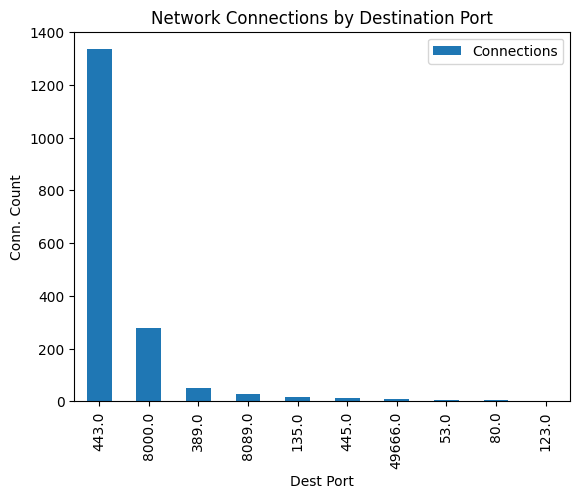

In [48]:
# Group and graph
ax = network_conns \
    .groupby("dest_port") \
    .count() \
    .reset_index() \
    .sort_values(by="pid", ascending=False) \
    .head(10) \
    .plot.bar(x="dest_port", y="pid", title="Network Connections by Destination Port")
ax.set_xlabel("Dest Port")
ax.set_ylabel("Conn. Count")
ax.legend(["Connections"])

Now that we have an overview, we can dive in on the points of interest in the dataset.

## Zooming In on Processes of Interest

Now we see some interesting processes right? `beacon.exe` in particular. We can do some really interesting graphing/tabling with that information.

Let's isolate that in a new slice and see what kind of events it emits. We'll do so with the `image` and `parent_image` properties, looking for what the process did, but also anything its immediate child processes did. Then we'll graph the events.

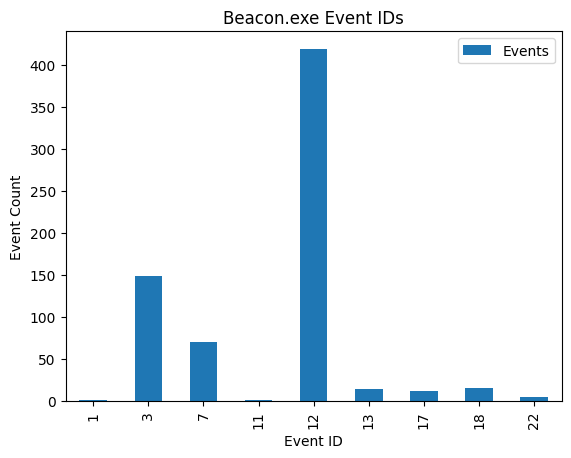

In [47]:
# Slice for beacon or beacon's kids
beacon_exe = df[df.image.str.endswith("beacon.exe") | df.parent_image.str.endswith("beacon.exe")]
# Graph Events
ax = beacon_exe.groupby("event_id").count().reset_index().plot.bar(x="event_id", y="pid", title="Beacon.exe Event IDs")
ax.set_xlabel("Event ID")
ax.set_ylabel("Event Count")
ax.legend(["Events"])

So a few process execs, a lot of network activity, some file writes? and a massive amount of registry activity. That's not exactly uncommon, but worth noting.

It's important to see that there are in fact network connections. To what?

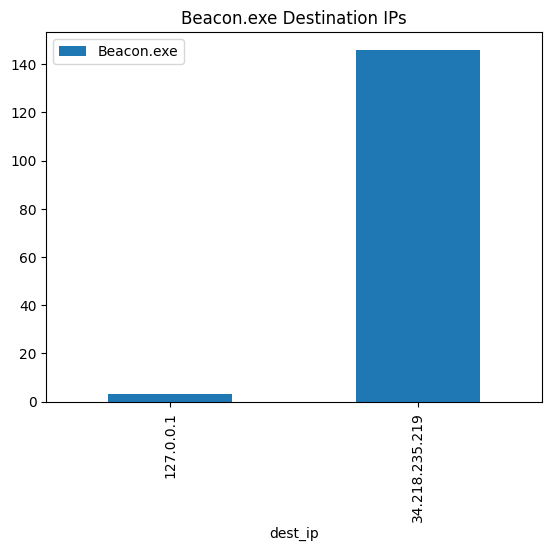

In [38]:
# Beacon Network Connections
ax = beacon_exe[beacon_exe.event_id == 3] \
    .groupby("dest_ip") \
    .count() \
    .reset_index() \
    .plot(kind="bar", x="dest_ip", y="pid", title="Beacon.exe Destination IPs")
ax.set_xlabel("Dest IP")
ax.set_ylabe("Conn. Count")
ax.legend(["Beacon.exe"])

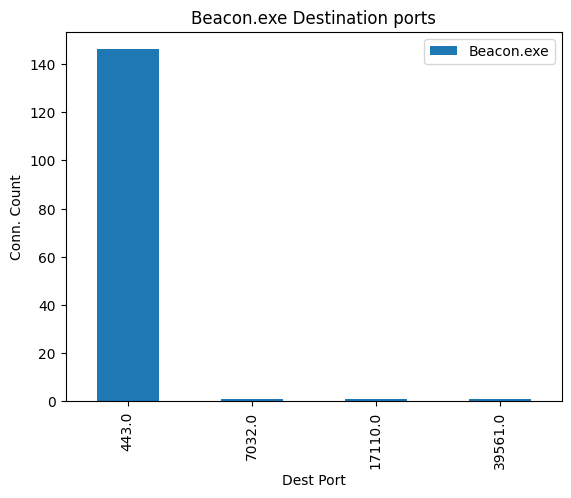

In [46]:
ax = beacon_exe[beacon_exe.event_id == 3] \
    .groupby("dest_port") \
    .count() \
    .reset_index() \
    .plot(kind="bar", x="dest_port", y="pid", title="Beacon.exe Destination ports")
ax.set_xlabel("Dest Port")
ax.set_ylabel("Conn. Count")
ax.legend(["Beacon.exe"])

Mostly on 443. Unsurprising, but that does mean we may have one other bit of data to grab: DNS, aka Event ID 22.

I think this may be nicer as a table.

In [43]:
# Check out event ID 22
beacon_exe[beacon_exe.event_id == 22][["time_created","query_name","query_results"]]

,time_created,query_name,query_results
412,2021-08-09T18:19:45.742406400Z,win-dc-58,10.0.1.14;
562,2021-08-09T18:19:46.742931100Z,schedule.catjamfest.com,::ffff:34.218.235.219;
1974,2021-08-09T18:20:46.738358300Z,vibing.catjamfest.com,::ffff:34.218.235.219;
2225,2021-08-09T18:20:52.170730500Z,festival.catjamfest.com,::ffff:34.218.235.219;
4071,2021-08-09T18:21:35.677197500Z,c2.catjamfest.com,::ffff:34.218.235.219;


![cobalt catjam](https://cdn.kapwing.com/final_636ebe45e39b74001de3a147_805139.gif)

Well hello there. Here we have a C2 calling home to multiple subdomains, but all resolving to the same IP.

There's plenty of other investigation we can undertake with this sample, but much of it may require a bit more complex visualization. That's why we're going to stop here for this lesson. 

Take some time to practice with `df.plot`. Try other chart types! Try stacked plots! 

In the next lesson, we'll explore more complex visualization libraries. See you there!